<a href="https://colab.research.google.com/github/amjad-alhaffar/dnnls_final_project/blob/main/Final_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

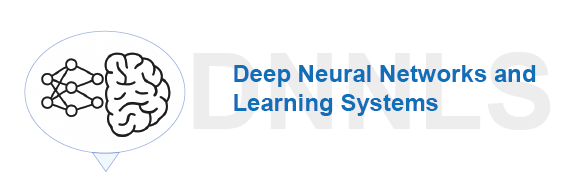

# Final assessment - Main Notebook
---

**Introduction:**

In this notebook you will find a baseline, functional architecture for your assessment task.

In [1]:
# @title Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np

# from google.colab import drive
import os

from datasets import load_dataset

from datasets.fingerprint import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT

from transformers import BertTokenizer
import gc

import textwrap


# **Chapter 1: The data preparation**


---



First we need to activate our google drive so that we can save out data permanently.

## 1.1 Loading and saving data

In [3]:

import os
import torch

RUNNING_ON_COLAB = True

if RUNNING_ON_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_DIR = "/content/gdrive/MyDrive"
else:
    # Your local Google Drive synced path (Windows)
    BASE_DIR = r"G:\My Drive"


CHECKPOINT_DIR = os.path.join(BASE_DIR, "DL_Checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_checkpoint_to_drive(model, optimizer, epoch, loss,
                    filename="autoencoder_checkpoint.pth"):

    full_path = os.path.join(CHECKPOINT_DIR, filename)

    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    }

    torch.save(checkpoint, full_path)
    print(f"Checkpoint saved: {full_path} (epoch {epoch})")


def load_checkpoint_from_drive(model, optimizer=None,
                    filename="autoencoder_checkpoint.pth",
                    device=None):

    full_path = os.path.join(CHECKPOINT_DIR, filename)

    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Checkpoint not found: {full_path}")

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    checkpoint = torch.load(full_path, map_location=device)

    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    epoch = checkpoint.get("epoch", 0)
    loss = checkpoint.get("loss", None)

    print(f"Checkpoint loaded: {full_path} (epoch {epoch})")
    return model, optimizer, epoch, loss


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


We need to define a couple of functions to make our life easier. Feel free to tweak those functions:

In [2]:
# @title Functions to load images and process data


# This function just extracts the tags from the text, don't get distracted by it.
# I changed this function a bit to fix some bugs
def parse_gdi_text(text):
    """Parse GDI formatted text into structured data"""
    soup = BeautifulSoup(text, 'html.parser')
    images = []

    for gdi in soup.find_all('gdi'):
        # Debug: print what BeautifulSoup sees

        # Method 1: Try to get image attribute directly
        image_id = None
        if gdi.attrs:
            # Check for attributes like 'image1', 'image2', etc.
            for attr_name, attr_value in gdi.attrs.items():
                if 'image' in attr_name.lower():
                    image_id = attr_name.replace('image', '')
                    break

        # Method 2: Extract from the tag string using regex
        if not image_id:
            tag_str = str(gdi)
            match = re.search(r'<gdi\s+image(\d+)', tag_str)
            if match:
                image_id = match.group(1)

        # Method 3: Fallback - use sequential numbering
        if not image_id:
            image_id = str(len(images) + 1)

        content = gdi.get_text().strip()

        # Extract tagged elements using BeautifulSoup directly
        objects = [obj.get_text().strip() for obj in gdi.find_all('gdo')]
        actions = [act.get_text().strip() for act in gdi.find_all('gda')]
        locations = [loc.get_text().strip() for loc in gdi.find_all('gdl')]

        images.append({
            'image_id': image_id,
            'description': content,
            'objects': objects,
            'actions': actions,
            'locations': locations,
            'raw_text': str(gdi)
        })

    return images

# This is an utility function to show images.
# Why do we need to do all this?
def show_image(ax, image, de_normalize = False, img_mean = None, img_std = None):
  """
  De-normalize the image (if necessary) and show image
  """
  if de_normalize:
    new_mean = -img_mean/img_std
    new_std = 1/img_std

    image = transforms.Normalize(
        mean=new_mean,
        std=new_std
    )(image)
  ax.imshow(image.permute(1, 2, 0))



Now we load dataset from HuggingFace:

In [8]:
# @title Loading the dataset
train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset = load_dataset("daniel3303/StoryReasoning", split="test")

In a previous lab, we analyzed the statistics of the images and figure out that a size of 240x500 could be good enough to standarize, but we will use 60x125. Also, we will restrict ourselves to taking only 5 frames from all the sequences.


## 1.2 Three datasets


---



We will create three different dataset objects and the corresponding loaders for performing multiple tasks

In [ ]:
# @title Only Text dataset
class SeqTextPredictionDataset(Dataset):
    def __init__(self, original_dataset, tokenizer,window_size=5, stride=4):
        super(SeqTextPredictionDataset, self).__init__()
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        self.window_size = window_size
        self.stride = stride
        self.windows = []
        for story_idx, example in enumerate(self.dataset):
            num_frames = example["frame_count"]
            if num_frames < window_size:
                continue  # skip very short stories

            # sliding windows with given stride
            for start in range(0, num_frames - window_size + 1, self.stride):
                self.windows.append((story_idx, start))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
      """
      Selects a 5 frame sequence from the dataset. Sets 4 for training and the last one
      as a target.
      """
      story_idx, start = self.windows[idx]
      example = self.dataset[story_idx]

      num_frames = example["frame_count"]
      # frames = example["images"]
      image_attributes = parse_gdi_text(example["story"])

      description_list = []
      obj_list = []
      act_list = []

      for offset in range(self.window_size - 1):
        frame_idx = start + offset
        # Potential experiments: Try using the other attributes in your training
        objects = image_attributes[frame_idx]["objects"]
        actions = image_attributes[frame_idx]["actions"]
        description = image_attributes[frame_idx]["description"]
        # We need to return the tokens for NLP
        input_ids =  self.tokenizer(
          description,
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=120
        ).input_ids
        object_ids =  self.tokenizer(
          ", ".join(objects),
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=20
        ).input_ids
        action_ids =  self.tokenizer(
          ", ".join(actions),
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=20
        ).input_ids

        description_list.append(input_ids.squeeze(0))
        obj_list.append(object_ids.squeeze(0))
        act_list.append(action_ids.squeeze(0))

      target_frame_idx = start + (self.window_size - 1)
      text_target = image_attributes[target_frame_idx]["description"]
      target_ids = self.tokenizer(
          text_target,
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=120).input_ids.squeeze(0)

      description_tensor = torch.stack(description_list)
      obj_tensor= torch.stack(obj_list)
      act_tensor= torch.stack(act_list)

      return (
              description_tensor,
              obj_tensor,
              act_tensor,
              target_ids,
              )



In [12]:
# @title text-image dataset
from transformers import CLIPTokenizer
import re
clip_tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14"
)
def clean_dialogue(text):
    # remove anything inside quotes (dialogue)
    text = re.sub(r'".*?"', '', text)
    text = re.sub(r"'.*?'", '', text)

    # remove leftover punctuation noise
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('\n', ' ').strip()

    return text

class DiffusionFrameDatasetExport(Dataset):
    def __init__(self, raw_dataset, transform=None, max_prompt_len=60):
        self.dataset = raw_dataset
        self.max_prompt_len = max_prompt_len

        self.transform = transform or transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
        ])

        self.samples = []
        for example in self.dataset:
            attrs = parse_gdi_text(example["story"])
            for i, img in enumerate(example["images"]):
                self.samples.append((img, attrs[i]["description"]))

    def __len__(self):
        return len(self.samples)

    def clean_prompt(self, text):
        text = text.lower()
        text = clean_dialogue(text)
        return " ".join(text.split()[:self.max_prompt_len])

    def __getitem__(self, idx):
        image, description = self.samples[idx]
        image = FT.equalize(image)
        image = self.transform(image)
        prompt = self.clean_prompt(description)

        return {
            "pixel_values": image,
            "prompt": prompt
        }



In [ ]:
# @title Main dataset
class SequencePredictionDataset(Dataset):
    def __init__(self, original_dataset, tokenizer,window_size=5, stride=4):
        super(SequencePredictionDataset, self).__init__()
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        self.window_size = window_size
        self.stride = stride
        # Potential experiments: Try other transforms!
        self.transform = transforms.Compose([
          transforms.Resize((60, 125)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])
        self.windows = []
        for story_idx, example in enumerate(self.dataset):
            num_frames = example["frame_count"]
            if num_frames < window_size:
                continue  # skip very short stories

            # sliding windows with given stride
            for start in range(0, num_frames - window_size + 1, self.stride):
                self.windows.append((story_idx, start))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
      """
      Selects a 5 frame sequence from the dataset. Sets 4 for training and the last one
      as a target.
      """
      story_idx, start = self.windows[idx]
      example = self.dataset[story_idx]

      num_frames = example["frame_count"]
      frames = example["images"]
      image_attributes = parse_gdi_text(example["story"])

      frame_tensors = []
      description_list = []
      obj_list = []
      act_list = []

      for offset in range(self.window_size - 1):
        frame_idx = start + offset
        image = FT.equalize(frames[frame_idx])
        input_frame = self.transform(image)
        frame_tensors.append(input_frame)
        # Potential experiments: Try using the other attributes in your training
        objects = image_attributes[frame_idx]["objects"]
        actions = image_attributes[frame_idx]["actions"]

        description = image_attributes[frame_idx]["description"]
        # We need to return the tokens for NLP
        input_ids =  self.tokenizer(
          description,
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=120
        ).input_ids
        object_ids =  self.tokenizer(
          ", ".join(objects),
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=20
        ).input_ids
        action_ids =  self.tokenizer(
          ", ".join(actions),
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=20
        ).input_ids

        description_list.append(input_ids.squeeze(0))
        obj_list.append(object_ids.squeeze(0))
        act_list.append(action_ids.squeeze(0))

      target_frame_idx = start + (self.window_size - 1)
      image_target = FT.equalize(frames[target_frame_idx])
      image_target = self.transform(image_target)
      text_target = image_attributes[target_frame_idx]["description"]
      target_ids = self.tokenizer(
          text_target,
          return_tensors="pt",
          padding="max_length",
          truncation=True,
          max_length=120).input_ids.squeeze(0)

      sequence_tensor = torch.stack(frame_tensors)
      description_tensor = torch.stack(description_list)
      obj_tensor= torch.stack(obj_list)
      act_tensor= torch.stack(act_list)

      return (sequence_tensor,
              description_tensor,
              obj_tensor,
              act_tensor,
              image_target,
              target_ids,
              )



We will use text autoencoding (reconstructing the same text) to develop representations of the text (I provide some existing weights for this, but you can train your own)

In [ ]:
# @title Text Autoencoder Dataset
class TextTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.index = []  # list of (story_idx, frame_idx)

        for story_idx, example in enumerate(self.dataset):
            num_frames = example["frame_count"]
            for frame_idx in range(num_frames):
                self.index.append((story_idx, frame_idx))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        story_idx, frame_idx = self.index[idx]
        example = self.dataset[story_idx]

        image_attributes = parse_gdi_text(example["story"])
        description = image_attributes[frame_idx]["description"]

        return description

And also a dataset for a potential image autoencoder task if you want to develop some visual features before training the whose archicture.

## 1.3 Creating and testing our dataset objects and loaders


---



In [ ]:
# @title For the Sequence prediction task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
sp_train_dataset = SeqTextPredictionDataset(train_dataset, tokenizer, window_size=5, stride=3)
sp_test_dataset  = SeqTextPredictionDataset(test_dataset,  tokenizer, window_size=5, stride=3)
print(len(sp_train_dataset))
print(len(sp_test_dataset))
# Let's do things properly, we will also have a validation split
# Split the training dataset into training and validation sets
train_size = int(0.8 * len(sp_train_dataset))
val_size = len(sp_train_dataset) - train_size
train_subset, val_subset = random_split(sp_train_dataset, [train_size, val_size])
print(sp_train_dataset)
print(sp_test_dataset)

# Instantiate the dataloaders
train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True,pin_memory=True)
# We will use the validation set to visualize the progress.
val_dataloader = DataLoader(val_subset, batch_size=32, shuffle=True,pin_memory=True        # try 4 or 8
    )
# test_dataloader = DataLoader(sp_test_dataset, batch_size=32, shuffle=False)


11458
2009


In [ ]:
 # @title For the text task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
text_dataset = TextTaskDataset(train_dataset)
text_dataloader = DataLoader(text_dataset, batch_size=4, shuffle=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Saved 100
Saved 200
Saved 300
Saved 400
Saved 500
Saved 600
Saved 700
Saved 800
Saved 900
Saved 1000
Finished. Total saved: 1000
Saved 100
Saved 200
Finished. Total saved: 200


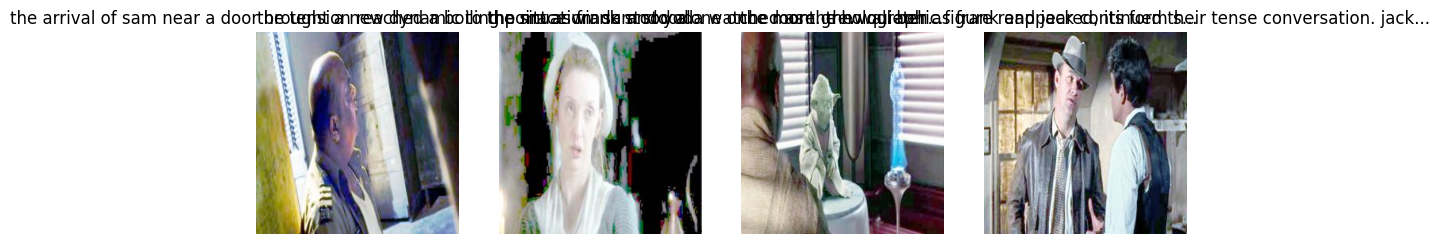

In [14]:
# @title For the text-image task

small_train_stories = train_dataset.select(range(200))
small_val_stories   = train_dataset.select(range(201, 240))


train_export_dataset = DiffusionFrameDatasetExport(
    small_train_stories,
    max_prompt_len=60
)

val_export_dataset = DiffusionFrameDatasetExport(
    small_val_stories,
    max_prompt_len=60
)


# train_image_dataloader = DataLoader(
#     train_image_dataset,
#     batch_size=1,
#     shuffle=True,   # randomness is inside dataset
#     num_workers=0,
#     pin_memory=False,
# )
# val_image_dataloader = DataLoader(
#     val_image_dataset,
#     batch_size=1,
#     shuffle=False,
#     num_workers=0,
#     pin_memory=False,
# )

# Add data files to collab
import os
os.makedirs("/content/data/train", exist_ok=True)
os.makedirs("/content/data/val", exist_ok=True)
from PIL import Image
import torchvision.transforms.functional as TF

import os, gc
from torchvision.transforms import functional as TF

def export_diffusion_dataset(dataset, out_dir, max_samples=1000):
    os.makedirs(out_dir, exist_ok=True)

    saved = 0
    N = len(dataset)

    for i in range(min(N, max_samples)):
        sample = dataset[i]   # ← INDEX ACCESS (important)

        image = sample["pixel_values"]
        prompt = sample["prompt"]

        pil_img = TF.to_pil_image(image)
        pil_img.save(os.path.join(out_dir, f"{saved:06d}.jpg"))

        with open(os.path.join(out_dir, f"{saved:06d}.txt"), "w") as f:
            f.write(prompt)

        # HARD cleanup
        del image, prompt, pil_img, sample
        gc.collect()

        saved += 1
        if saved % 100 == 0:
            print(f"Saved {saved}")

    print(f"Finished. Total saved: {saved}")


export_diffusion_dataset(
    train_export_dataset,
    "/content/data/train",
    max_samples=1000
)

export_diffusion_dataset(
    val_export_dataset,
    "/content/data/val",
    max_samples=200
)

# show sample
import random
import matplotlib.pyplot as plt

def show_random_samples(data_dir, n=4):
    files = [f for f in os.listdir(data_dir) if f.endswith(".jpg")]
    samples = random.sample(files, n)

    plt.figure(figsize=(12,3))
    for i, f in enumerate(samples):
        img = Image.open(os.path.join(data_dir, f))
        with open(os.path.join(data_dir, f.replace(".jpg", ".txt"))) as t:
            prompt = t.read()

        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(prompt[:80] + "...")

    plt.show()

show_random_samples("/content/data/train")

In [ ]:
# @title train the model
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="scheduler"
)

for step, batch in enumerate(train_dataloader):
    pixel_values = batch["pixel_values"].to("cuda", dtype=torch.float16)
    input_ids = batch["input_ids"].to("cuda")

    latents = pipe.vae.encode(pixel_values).latent_dist.sample()
    latents = latents * 0.18215

    noise = torch.randn_like(latents)
    timesteps = torch.randint(
        0, noise_scheduler.config.num_train_timesteps,
        (latents.shape[0],), device=latents.device
    )

    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

    encoder_hidden_states = pipe.text_encoder(input_ids)[0]

    noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

    loss = torch.nn.functional.mse_loss(noise_pred, noise)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if step % 100 == 0:
        print(step, loss.item())


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# @title Testing some of the outputs of the SP dataset
(
    descriptions,
    objects,
    actions,
    target_desc,
) = sp_train_dataset[np.random.randint(0, len(sp_train_dataset))]

print("Description: ", descriptions.shape)
print("Descriptions shape:", descriptions)
print("Objects shape:", objects)
print("Actions shape:", actions)
print("Target desc shape:", target_desc)
# Do some tests on the batches (try with batch size small)
# (
#     frames,
#     descriptions,
#     objects,
#     actions,
#     image_target,
#     target_desc,
#     target_obj,
#     target_act
# ) = next(iter(train_dataloader))
# print(frames.shape)
# print(descriptions.shape)

Train counts by frame_count:
5 frames: 385 stories
6 frames: 267 stories
7 frames: 239 stories
8 frames: 207 stories
9 frames: 170 stories
10 frames: 180 stories
11 frames: 152 stories
12 frames: 139 stories
13 frames: 125 stories
14 frames: 116 stories
15 frames: 109 stories
16 frames: 161 stories
17 frames: 723 stories
18 frames: 334 stories
19 frames: 94 stories
20 frames: 68 stories
21 frames: 62 stories
22 frames: 21 stories


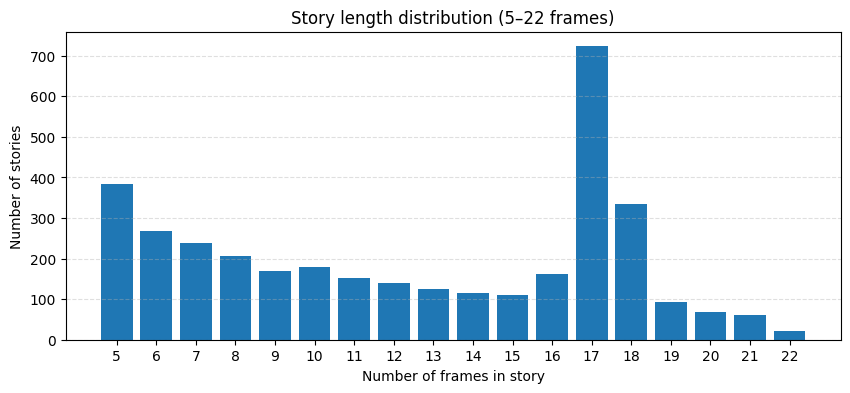

In [ ]:
# @title Data Visualization
from collections import Counter
import matplotlib.pyplot as plt

# Count frames from dataset
frame_counter_train = Counter()
for example in train_dataset:
    num_frames = example["frame_count"]
    frame_counter_train[num_frames] += 1

min_len = min(5)
max_len = max(frame_counter_train.keys())
lengths = list(range(min_len, max_len + 1))
counts = [frame_counter_train.get(l, 0) for l in lengths]
# Plot
plt.figure(figsize=(10, 4))
plt.bar(lengths, counts)
plt.xticks(lengths)
plt.xlabel("Number of frames in story")
plt.ylabel("Number of stories")
plt.title(f"Story length distribution ({min_len}–{max_len} frames)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


I will leave the test of the other datasets to you.

# **Chapter 2: Models**


---



We provide a simple text encoder based on a recurrent neural network (LSTM). Feel free to provide your own text encoder.

## 2.1 The NLP models

In [3]:
# @title Bert wrapper
class BertAutoencoderWrapper(nn.Module):
    def __init__(self, bert_mlm_model):
        super().__init__()
        self.bert = bert_mlm_model.bert        # encoder
        self.cls = bert_mlm_model.cls          # MLM head

    def encoder(self, input_ids):
        """
        Returns (dummy_output, hidden, cell)
        We'll use the [CLS] token embedding as 'hidden'.
        """
        outputs = self.bert(input_ids)
        hidden_state = outputs.last_hidden_state
        cls_token = hidden_state[:, 0, :]
        return None, cls_token.unsqueeze(0), None

    def decoder(self, input_ids, h0, c0):
        outputs = self.bert(input_ids)
        sequence_output = outputs.last_hidden_state
        prediction_scores = self.cls(sequence_output)
        # return logits in same format as before
        return prediction_scores, h0, c0


In [ ]:
# @title The text autoencoder (Seq2Seq)

class EncoderLSTM(nn.Module):
    """
      Encodes a sequence of tokens into a latent space representation.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    """
      Decodes a latent space representation into a sequence of tokens.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_dim, vocab_size) # Should be hidden_dim

    def forward(self, input_seq, hidden, cell):
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell

# We create the basic text autoencoder (a special case of a sequence to sequence model)
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, target_seq):
        # input_seq and target_seq are both your 'input_ids'
        # 1. Encode the input sequence
        _enc_out, hidden, cell = self.encoder(input_seq)

        # 2. Create the "shifted" decoder input for teacher forcing.
        # We want to predict target_seq[:, 1:]
        # So, we feed in target_seq[:, :-1]
        # (i.e., feed "[SOS], hello, world" to predict "hello, world, [EOS]")
        decoder_input = target_seq[:, :-1]

        # 3. Run the decoder *once* on the entire sequence.
        # It takes the encoder's final state (hidden, cell)
        # and the full "teacher" sequence (decoder_input).
        predictions, _hidden, _cell = self.decoder(decoder_input, hidden, cell)

        # predictions shape will be (batch_size, seq_len-1, vocab_size)
        return predictions


In [27]:
# @title Generate helper fucntion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
@torch.no_grad()
def generate(
    model,
    desc_emb,
    obj_emb,
    act_emb,
    tokenizer,
    max_len,
    temperature=0.7
):
    device = desc_emb.device

    # ---------- projections ----------
    desc = model.text_proj(desc_emb)   # [B, S, D]
    obj  = model.obj_proj(obj_emb)
    act  = model.act_proj(act_emb)

    # ---------- gated conditioning ----------
    cond = torch.cat([obj, act], dim=-1)          # [B, S, 2D]
    gate = torch.sigmoid(model.gate_layer(cond))  # [B, S, D]
    desc = desc * gate                             # [B, S, D]

    # ---------- temporal reasoning ----------
    zseq, _ = model.temporal_rnn(desc)             # [B, S, D]

    # ---------- attention ----------
    context = model.attention(zseq)                # [B, D]
    h_last = zseq[:, -1]                            # [B, D]

    z = model.projection(torch.cat([h_last, context], dim=1))  # [B, H]

    # ---------- decoder init ----------
    num_layers = model.text_decoder.gru.num_layers
    h0 = z.unsqueeze(0).repeat(num_layers, 1, 1)

    # ---------- autoregressive decoding ----------
    sos = tokenizer.cls_token_id
    eos = tokenizer.sep_token_id

    generated = torch.tensor([[sos]], device=device)

    for _ in range(max_len):
        logits = model.text_decoder(generated, h0)
        next_logits = logits[:, -1, :] / temperature
        probs = torch.softmax(next_logits, dim=-1)
        next_token = torch.multinomial(probs, 1)

        if next_token.item() == eos:
            break

        generated = torch.cat([generated, next_token], dim=1)

    return tokenizer.decode(generated[0], skip_special_tokens=True)



In [ ]:
# @title Do some tests
desc = text_dataset[np.random.randint(0, 100)]
print(f"Input: {desc}")
input_ids = tokenizer(desc, return_tensors="pt",  padding=True, truncation=True).input_ids
input_ids = input_ids.to(device)
generated_tokens = generate(model, hidden, cell, max_len=100, sos_token_id=tokenizer.cls_token_id, eos_token_id=tokenizer.sep_token_id)
print("Output: ", tokenizer.decode(generated_tokens))

NameError: name 'text_dataset' is not defined

## 2.2 The Vision models

In [ ]:
# @title Loading The visual model
!pip install diffusers transformers accelerate peft




## 2.3 The main architecture


In [5]:
# @title A simple attention architecture

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # This "attention" layer learns a query vector
        self.attn = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1) # Over the sequence length

    def forward(self, rnn_outputs):
        # rnn_outputs shape: [batch, seq_len, hidden_dim]

        # Pass through linear layer to get "energy" scores
        energy = self.attn(rnn_outputs).squeeze(2) # Shape: [batch, seq_len]

        # Get attention weights
        attn_weights = self.softmax(energy) # Shape: [batch, seq_len]

        # Apply weights
        # attn_weights.unsqueeze(1) -> [batch, 1, seq_len]
        # bmm with rnn_outputs -> [batch, 1, hidden_dim]
        context = torch.bmm(attn_weights.unsqueeze(1), rnn_outputs)

        # Squeeze to get final context vector
        return context.squeeze(1) # Shape: [batch, hidden_dim]

In [7]:
# @title The main sequence predictor model
class TextDecoderGRU(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        hidden_dim,
        num_layers=2,
        dropout=0.3
    ):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, emb_dim)

        self.gru = nn.GRU(
            emb_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_ids, h0):
        emb = self.embedding(input_ids)      # [B, T, E]
        out, _ = self.gru(emb, h0)            # [B, T, H]
        out = self.dropout(out)
        logits = self.fc(out)                 # [B, T, V]
        return logits


class SequencePredictorCached(nn.Module):
    def __init__(self, latent_dim, vocab_size):
        super().__init__()

        # projections
        self.text_proj = nn.Linear(768, latent_dim)
        self.obj_proj  = nn.Linear(768, latent_dim)
        self.act_proj  = nn.Linear(768, latent_dim)


        # Gating
        self.gate_layer = nn.Linear(latent_dim * 2, latent_dim)

        # Temporal
        self.temporal_rnn = nn.GRU(latent_dim, latent_dim, batch_first=True)

        # Attention over frames
        self.attention = Attention(latent_dim)

        # Final fusion
        self.projection = nn.Sequential(
            nn.Linear(latent_dim * 2, latent_dim),
            nn.ReLU()
        )

        # decoder
        self.text_decoder = TextDecoderGRU(
            vocab_size=vocab_size,
            emb_dim=latent_dim,
            hidden_dim=latent_dim,
            num_layers=2,
            dropout=0.1
        )

    def forward(self, desc_emb, obj_emb, act_emb, target_seq):

        # Project BERT CLS per frame
        desc = self.text_proj(desc_emb)  # [B, S, D]
        obj  = self.obj_proj(obj_emb)
        act  = self.act_proj(act_emb)

        # conditioning
        cond = torch.cat([obj, act], dim=-1)     # [B, S, 2D]
        gate = torch.sigmoid(self.gate_layer(cond))
        desc = desc * gate                       # [B, S, D]

        # Temporal
        zseq, _ = self.temporal_rnn(desc)        # [B, S, D]

        # Attention
        context = self.attention(zseq)           # [B, D]
        h_last  = zseq[:, -1]                    # [B, D]

        # Fuse
        z = self.projection(torch.cat([h_last, context], dim=1))

        # Decoder init
        h0 = z.unsqueeze(0).repeat(
            self.text_decoder.gru.num_layers, 1, 1
        )

        # Teacher forcing
        decoder_input = target_seq[:, :-1]
        logits = self.text_decoder(decoder_input, h0)

        return logits


# **Chapter 3: Training routines**


---




In [6]:
# @title Adding Metrices
!pip install rouge-score
from rouge_score import rouge_scorer

def compute_rouge_l(pred_texts, ref_texts):
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    scores = []
    for pred, ref in zip(pred_texts, ref_texts):
        score = scorer.score(ref, pred)["rougeL"].fmeasure
        scores.append(score)
    return sum(scores) / len(scores)

rouge_scorer_single = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def rouge_l_single(pred_text, ref_text):
    return rouge_scorer_single.score(ref_text, pred_text)["rougeL"].fmeasure

!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
import torch.nn.functional as F

semantic_model = SentenceTransformer("all-MiniLM-L6-v2").to(device)
semantic_model.eval()

def compute_semantic_similarity(pred_texts, ref_texts):
    sims = []
    with torch.no_grad():
        for pred, ref in zip(pred_texts, ref_texts):
            emb = semantic_model.encode(
                [pred, ref],
                convert_to_tensor=True,
                device=device
            )
            sim = F.cosine_similarity(emb[0], emb[1], dim=0)
            sims.append(sim.item())
    return sum(sims) / len(sims)

# !pip install sacrebleu
# from sacrebleu import corpus_bleu

# def compute_bleu(pred_texts, ref_texts):
#     """
#     pred_texts: List[str]
#     ref_texts:  List[str]
#     """
#     bleu = corpus_bleu(pred_texts, [ref_texts])
#     return bleu.score



  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2ffa29fb6208b1b7041f65161acbd8d473f07d8c8d6059f932924d6a1f1cd017
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [22]:
# @title Validation functions: To initialize and to visualize the progress
def validation(model, data_loader, criterion, max_gen_len=120):
    model.eval()

    total_loss = 0.0
    total_tokens = 0
    pred_texts = []
    ref_texts  = []
    printed_sample = False

    with torch.no_grad():
        for desc_emb, obj_emb, act_emb, text_target in data_loader:

            desc_emb = desc_emb.to(device)
            obj_emb  = obj_emb.to(device)
            act_emb  = act_emb.to(device)
            text_target = text_target.to(device)

            # ---------- Teacher forcing ----------
            logits = model(desc_emb, obj_emb, act_emb, text_target)

            target_labels = text_target[:, 1:]
            prediction_flat = logits.reshape(-1, tokenizer.vocab_size)
            target_flat = target_labels.reshape(-1)

            loss = criterion(prediction_flat, target_flat)

            total_loss += loss.item() * target_flat.size(0)
            total_tokens += target_flat.size(0)

            # ---------- Generation (for metrics) ----------
            pred_text = generate(
                model,
                desc_emb[:1],
                obj_emb[:1],
                act_emb[:1],
                tokenizer=tokenizer,
                max_len=max_gen_len,
                temperature=0.7
            )

            ref_text = tokenizer.decode(
                text_target[0], skip_special_tokens=True
            )

            pred_texts.append(pred_text)
            ref_texts.append(ref_text)

            # ---------- Print ONE qualitative example ----------
            if not printed_sample:
                printed_sample = True
                import textwrap
                print("\n" + "=" * 80)
                print("TARGET:")
                print(textwrap.fill(ref_text, 100))
                print("\nPREDICTED:")
                print(textwrap.fill(pred_text, 100))
                print("=" * 80 + "\n")

    avg_loss = total_loss / total_tokens
    avg_rouge = compute_rouge_l(pred_texts, ref_texts)

    # semantic similarity averaged properly
    avg_sem = compute_semantic_similarity(pred_texts, ref_texts)

    return avg_loss, avg_rouge, avg_sem


## 3.1 Initialization and setup

## 3.2 Training loops

In [7]:
# @title Text autoencoder before caching Bert

from transformers import BertTokenizer, BertForMaskedLM

torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
N_EPOCHS=50
latent_dim = 128
gru_hidden_dim = 128


tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
criterion_text = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))


bert_mlm  = BertForMaskedLM.from_pretrained("google-bert/bert-base-uncased")
if RUNNING_ON_COLAB:
    bert_mlm.load_state_dict(
        torch.load("/content/gdrive/MyDrive/bert_mlm_finetuned.pth", map_location=device)
    )
else:
    bert_mlm.load_state_dict(
        torch.load(r"G:\My Drive\bert_mlm_finetuned.pth", map_location=device)
    )

text_autoencoder = BertAutoencoderWrapper(bert_mlm).to(device)
# freeze
for param in text_autoencoder.parameters():
    param.requires_grad = False
bert_trainable = sum(p.numel() for p in text_autoencoder.parameters() if p.requires_grad)
print(f"BERT trainable params: {bert_trainable}")

text_autoencoder.eval()

cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT trainable params: 0


BertAutoencoderWrapper(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [20]:
# @title Semantic text loss
from sentence_transformers import SentenceTransformer
import torch.nn.functional as F

semantic_model = SentenceTransformer("all-MiniLM-L6-v2").to(device)
semantic_model.eval()
def semantic_loss(pred_texts, ref_texts):
    with torch.no_grad():  # IMPORTANT: no gradients here
        emb_pred = semantic_model.encode(
            pred_texts,
            convert_to_tensor=True,
            device=device
        )
        emb_ref = semantic_model.encode(
            ref_texts,
            convert_to_tensor=True,
            device=device
        )

        sim = F.cosine_similarity(emb_pred, emb_ref, dim=1)
        loss = 1.0 - sim.mean()

    return loss


In [ ]:
# @title Caching BERT embeddings for train/val/test
from tqdm.auto import tqdm

def cach_data(name, loader):
    desc_embs, obj_embs, act_embs, targets = [], [], [], []
    text_autoencoder.eval()

    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Caching {name}"):
            descriptions, objects, actions, text_target = batch
            descriptions = descriptions.to(device)
            objects = objects.to(device)
            actions = actions.to(device)

            # dynamic dims
            b, seq_len, desc_len = descriptions.shape
            obj_len = objects.shape[2]
            act_len = actions.shape[2]

            # flatten first two dims
            desc_flat = descriptions.view(b * seq_len, desc_len)
            obj_flat  = objects.view(b * seq_len, obj_len)
            act_flat  = actions.view(b * seq_len, act_len)

            # run BERT
            desc_out = text_autoencoder.bert(desc_flat).last_hidden_state[:, 0, :].cpu()
            obj_out  = text_autoencoder.bert(obj_flat).last_hidden_state[:, 0, :].cpu()
            act_out  = text_autoencoder.bert(act_flat).last_hidden_state[:, 0, :].cpu()

            # reshape back
            hidden_dim = desc_out.size(-1)  # should be 768
            desc_out = desc_out.view(b, seq_len, hidden_dim)
            obj_out  = obj_out.view(b, seq_len, hidden_dim)
            act_out  = act_out.view(b, seq_len, hidden_dim)

            desc_embs.append(desc_out)
            obj_embs.append(obj_out)
            act_embs.append(act_out)
            targets.append(text_target.cpu())

    # concatenate all
    desc_embs = torch.cat(desc_embs)
    obj_embs  = torch.cat(obj_embs)
    act_embs  = torch.cat(act_embs)
    targets   = torch.cat(targets)

    torch.save({
        "desc": desc_embs,
        "obj": obj_embs,
        "act": act_embs,
        "target": targets
    }, f"/content/gdrive/MyDrive/BERTcach/cached_bert_embeddings_{name}.pt")

    print(f"✅ Cached {name} BERT features saved successfully!")

# Run for all
cach_data("train", train_dataloader)
# cach_data("val", val_dataloader)
# cach_data("test", test_dataloader)


Caching train:   0%|          | 0/287 [00:00<?, ?it/s]

✅ Cached train BERT features saved successfully!


In [23]:
# @title Load cached embeddings to speed the training
class CachedSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, cache_path):
        data = torch.load(cache_path)
        self.desc = data["desc"]
        self.obj = data["obj"]
        self.act = data["act"]
        self.target = data["target"]

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return (
            self.desc[idx],
            self.obj[idx],
            self.act[idx],
            self.target[idx]
        )

cached_dataset = CachedSequenceDataset("/content/gdrive/MyDrive/BERTcach/cached_bert_embeddings_train.pt")
cached_dataset_val = CachedSequenceDataset("/content/gdrive/MyDrive/BERTcach/cached_bert_embeddings_val.pt")
cached_dataset_test = CachedSequenceDataset("/content/gdrive/MyDrive/BERTcach/cached_bert_embeddings_test.pt")
train_dataloader_c = DataLoader(cached_dataset, batch_size=64, shuffle=True)
val_dataloader_c = DataLoader(cached_dataset_val, batch_size=32, shuffle=True)
test_dataloader_c = DataLoader(cached_dataset_test, batch_size=16, shuffle=False)


In [24]:
# @title Main pipline cached
sequence_predictor = SequencePredictorCached(
    latent_dim=128,
    vocab_size=tokenizer.vocab_size
).to(device)

# Print model size
predictor_trainable = sum(p.numel() for p in sequence_predictor.parameters() if p.requires_grad)
print(f"Predictor trainable params: {predictor_trainable}")

optimizer = torch.optim.Adam(sequence_predictor.parameters(),  lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
)


Predictor trainable params: 8502587


In [28]:
# @title Training loop for the sequence predictor
SEMANTIC_START_EPOCH = 10
SEMANTIC_WEIGHT = 0.1

start_epoch = 0

try:
    sequence_predictor, optimizer, last_epoch, _ = load_checkpoint_from_drive(
        sequence_predictor,
        optimizer,
        filename=f"sequence_predictor_decoder{start_epoch}.pth"
    )
    start_epoch = last_epoch + 1
except FileNotFoundError:
    print("Starting from scratch")

sequence_predictor.train()
train_losses = []
val_losses   = []

val_rouge_l  = []
val_sem_sim  = []
print('haha')
print(len(train_dataloader_c))
for epoch in range(start_epoch, N_EPOCHS):
    running_loss = 0.0
    for step,(descriptions, objects, actions, text_target)  in enumerate(train_dataloader_c):
      # Send images and tokens to the GPU
      descriptions = descriptions.to(device)
      act_seq = actions.to(device)
      obj_seq = objects.to(device)
      text_target = text_target.to(device)

      # Predictions from our model
      predicted_text_logits = sequence_predictor(
        descriptions,obj_seq, act_seq , text_target
      )
      # Computing losses

      # Loss function for the text prediction
      prediction_flat = predicted_text_logits.reshape(-1, tokenizer.vocab_size)
      target_labels = text_target.squeeze(1)[:, 1:] # Slice to get [8, 119]
      target_flat = target_labels.reshape(-1)
      loss = criterion_text(prediction_flat, target_flat)

      # ---- semantic auxiliary loss after 10 epochs ----
      if epoch >= SEMANTIC_START_EPOCH:
          was_training = sequence_predictor.training
          sequence_predictor.eval()
          with torch.no_grad():
            pred_text = generate(
                sequence_predictor,
                descriptions[:1],
                obj_seq[:1],
                act_seq[:1],
                tokenizer=tokenizer,
                max_len=120,
                temperature=0.7
            )

          if was_training:
              sequence_predictor.train()               # restore state

          ref_text = tokenizer.decode(
              text_target[0],
              skip_special_tokens=True
          )

      sem_loss = semantic_loss([pred_text], [ref_text])

      loss = loss + SEMANTIC_WEIGHT * sem_loss
      # Optimizing
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * descriptions.size(0)

    sequence_predictor.eval()

    avg_train_loss = running_loss / len(train_dataloader_c.dataset)
    train_losses.append(avg_train_loss)

    # ---------------- VALIDATION ----------------
    sequence_predictor.eval()

    val_loss, rouge_l_val, sem_sim_val = validation(
        sequence_predictor,
        val_dataloader_c,
        criterion_text
    )

    val_losses.append(val_loss)
    val_rouge_l.append(rouge_l_val)
    val_sem_sim.append(sem_sim_val)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"ROUGE-L: {rouge_l_val:.4f} | "
        f"Semantic: {sem_sim_val:.4f}"
    )

    scheduler.step(val_loss)
    sequence_predictor.train()

    if (epoch + 1) % 5 == 0:
        save_checkpoint_to_drive(
            sequence_predictor,
            optimizer,
            epoch + 1,
            avg_train_loss,
            filename=f"sequence_predictor_decoder{epoch+1}.pth"
        )


Starting from scratch
haha
144

TARGET:
the scene was chaotic as frank lay motionless on the ground. frank ’ s injured body was a grim
reminder of the dangers they faced. samuel knelt beside frank, his face etched with worry. the dark
and shadowy background seemed to close in, amplifying the tension. samuel knew that this was the
turning point. the group had to regroup and find a way to continue their mission, despite the
setback. the atmosphere was heavy with determination as samuel and mike worked to revive frank.

PREDICTED:
the scene shifted to a dimly lit room, where emily stood the wall, their hands filled with fear. a
woman in the background, she remained alert. the desert was a constant reminder of the challenges
they were about to happen. the sky above them seemed to whisper secrets that had far from over. the
door and wall seemed to echo his inner turmoil, wondering if they were determined to uncover the
answers he faced. the air was thick with anticipation, but the mystery w

In [19]:
!pip uninstall -y diffusers
!pip install git+https://github.com/huggingface/diffusers.git


Found existing installation: diffusers 0.36.0
Uninstalling diffusers-0.36.0:
  Successfully uninstalled diffusers-0.36.0
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-q8fvrq3k
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-q8fvrq3k
  Resolved https://github.com/huggingface/diffusers.git to commit 47378066c002573613a1dba686570fbd5a1cf48a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.36.0.dev0-py3-none-any.whl size=4730558 sha256=8bf578faa5d1a4f62681ac4ef96c46269f99236ff2365fd9914b2d763de98176
  Stored in directory: /tmp/pip-ephem-wheel-cache-6agrqfzv/wheels/23/0f/7d/f97813d265ed0e599a78d83afd4e1925740896ca79b46cccfd
Successfully built diffusers


In [3]:
# @title LoRA Text-image Training
!accelerate launch diffusers/examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --dataset_name="imagefolder" \
  --train_data_dir="/content/data/train" \
  --resolution=256 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=8 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --max_train_steps=1500 \
  --checkpointing_steps=500 \
  --mixed_precision="fp16" \
  --output_dir="/content/lora-output"






The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2026-01-05 00:17:02.280150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767572222.316514    9765 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767572222.328019    9765 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767572222.352438    9765 computation_plac

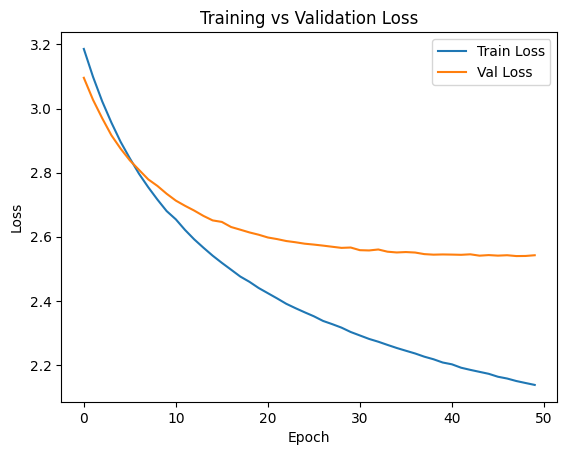

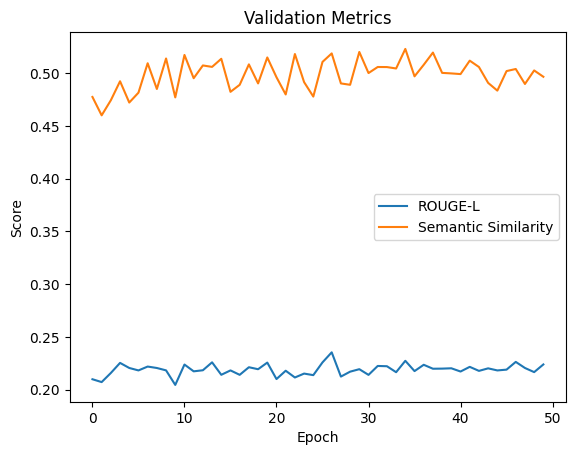


TARGET:
the confrontation continued as anon leader stood among the soldiers. the air was thick with tension,
and they tried to decipher the meaning behind the masked figure. anon leader spoke again, “ we are
not your enemies. we are the voice of the people. ” the soldiers remained silent, unsure of how to
respond.

PREDICTED:
in the midst of the chaos, farmer continued to observe the scene with a neutral expression. he spoke
with a sense of authority, his voice laced with urgency. “ we must be vigilant, " ben declared, his
voice steady despite the importance of his mission. the private is the military uniform, the leader,
slightly under his face, but the gravity of the situation was too much to bear. the mission was far
from over, and the team knew that they had to stay strong.

TEST SET PERFORMANCE
Loss: 2.8401
ROUGE-L: 0.2175
Semantic Similarity: 0.5072


In [29]:
# @title Description Task Results
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

plt.figure()
plt.plot(val_rouge_l, label="ROUGE-L")
plt.plot(val_sem_sim, label="Semantic Similarity")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.title("Validation Metrics")
plt.show()

test_loss, test_rouge, test_sem = validation(
    sequence_predictor,
    test_dataloader_c,
    criterion_text
)

print("TEST SET PERFORMANCE")
print(f"Loss: {test_loss:.4f}")
print(f"ROUGE-L: {test_rouge:.4f}")
print(f"Semantic Similarity: {test_sem:.4f}")


In [ ]:
# @title Example text reconstruction task
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
import os

print(os.path.exists("/content/gdrive/MyDrive"))


emb_dim = 32
latent_dim = 32
num_layers = 1
dropout = 0.1

# Don't forget to unfreeze the model!
from transformers import BertTokenizer, BertForMaskedLM
from torch.optim import AdamW

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased", padding=True, truncation=True)
text_dataset = TextTaskDataset(train_dataset)
text_dataset.index = text_dataset.index[:10000]
text_dataloader = DataLoader(text_dataset, batch_size=32, shuffle=True)
tokens = tokenizer(text_dataset[0])
print(len(tokens["input_ids"]))

print("Number of descriptions in training set:", len(text_dataset))
print("Number of batches per epoch:", len(text_dataloader))
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,  # 15% of tokens masked (default)
)


cuda
True
92
Number of descriptions in training set: 10000
Number of batches per epoch: 313


In [ ]:
#original text encoder
# @title Original LSTM text autoencoder

# Don't forget to unfreeze the model!
optimizer = torch.optim.Adam(text_autoencoder.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))

from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()  # helps stabilize mixed precision training

N_EPOCHS = 25
for epoch in range(N_EPOCHS):
    text_autoencoder.train()
    epoch_loss = 0.0

    for step, descriptions in enumerate(text_dataloader):
        batch = tokenizer(
            descriptions,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)

        input_ids = batch["input_ids"]

        optimizer.zero_grad()

        # Mixed precision forward + backward
        with autocast():
            outputs = text_autoencoder(input_ids, input_ids)
            loss = loss_fn(
                outputs.reshape(-1, tokenizer.vocab_size),
                input_ids[:, 1:].reshape(-1)
            )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        if step % 100 == 0:
            print(f"[Epoch {epoch+1}] Step {step} | Loss: {loss.item():.4f}")

    avg_loss = epoch_loss / len(text_dataloader)
    print(f"Epoch {epoch+1}/{N_EPOCHS} | Avg loss: {avg_loss:.4f}")

    if (epoch + 1) % 5 == 0:
        torch.save(text_autoencoder.state_dict(), f"/content/seq2seq-epoch-{epoch+1}.pth")
        print("saved")

# Final save to Drive
save_checkpoint_to_drive(
    text_autoencoder, optimizer, N_EPOCHS, loss, filename="text_autoencoder_new.pth"
)


/tmp/ipython-input-1094628550.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # helps stabilize mixed precision training
/tmp/ipython-input-1094628550.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1] Step 0 | Loss: 5.6492
[Epoch 1] Step 100 | Loss: 5.4628
[Epoch 1] Step 200 | Loss: 5.2818
[Epoch 1] Step 300 | Loss: 5.0400
Epoch 1/25 | Avg loss: 5.3082
[Epoch 2] Step 0 | Loss: 5.0854
[Epoch 2] Step 100 | Loss: 4.9106
[Epoch 2] Step 200 | Loss: 4.3333
[Epoch 2] Step 300 | Loss: 4.6084
Epoch 2/25 | Avg loss: 4.7326
[Epoch 3] Step 0 | Loss: 4.5255
[Epoch 3] Step 100 | Loss: 4.3557
[Epoch 3] Step 200 | Loss: 4.5406
[Epoch 3] Step 300 | Loss: 4.2378
Epoch 3/25 | Avg loss: 4.3670
[Epoch 4] Step 0 | Loss: 4.2942
[Epoch 4] Step 100 | Loss: 4.2676
[Epoch 4] Step 200 | Loss: 4.0596
[Epoch 4] Step 300 | Loss: 4.1356
Epoch 4/25 | Avg loss: 4.1282
[Epoch 5] Step 0 | Loss: 4.2851
[Epoch 5] Step 100 | Loss: 4.0179
[Epoch 5] Step 200 | Loss: 4.0192
[Epoch 5] Step 300 | Loss: 3.9271
Epoch 5/25 | Avg loss: 3.9590
[Epoch 6] Step 0 | Loss: 3.8582
[Epoch 6] Step 100 | Loss: 3.7631
[Epoch 6] Step 200 | Loss: 3.7258
[Epoch 6] Step 300 | Loss: 4.0124
Epoch 6/25 | Avg loss: 3.8290
[Epoch 7] Step 0

In [ ]:
# @title BERT Model
#BERT MLM model
model = BertForMaskedLM.from_pretrained("google-bert/bert-base-uncased").to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(N_EPOCHS):
    model.train()
    epoch_loss = 0.0
    num_batches = len(text_dataloader)
    for step, descriptions in enumerate(text_dataloader):
        # Move the "sentences" to device
        batch = tokenizer(
            descriptions,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=100
        )
        # Move whole batch dict to device
        batch = {k: v.to(device) for k, v in batch.items()}
        examples = [
            {"input_ids": ids, "attention_mask": mask}
            for ids, mask in zip(batch["input_ids"], batch["attention_mask"])
        ]
        masked_batch = data_collator(examples)
        masked_batch = {k: v.to(device) for k, v in masked_batch.items()}
        outputs = model(**masked_batch)

        loss = outputs.loss
        optimizer.zero_grad()

        # outputs = text_autoencoder(input_ids, input_ids)
        # compute the loss: compare 3D logits to 2D targets
        # loss = loss_fn(outputs.reshape(-1, tokenizer.vocab_size), input_ids[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 50 == 0:
          print(f"[Epoch {epoch+1}] Step {step}/{num_batches} | Loss: {loss.item():.4f}")
    print(f"Epoch {epoch+1}/{N_EPOCHS}; Avg loss {epoch_loss/len(text_dataloader)}; Latest loss {loss.item()}")
    torch.save(model.state_dict(), "/content/drive/MyDrive/bert_mlm_finetuned.pth")

# saving checkpoint to drive
# save_checkpoint_to_drive(model, optimizer, 3*N_EPOCHS, loss, filename = "model.pth")

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[Epoch 1] Step 0/313 | Loss: 2.0236
[Epoch 1] Step 50/313 | Loss: 1.1548
[Epoch 1] Step 100/313 | Loss: 1.2742
[Epoch 1] Step 150/313 | Loss: 0.9993
[Epoch 1] Step 200/313 | Loss: 1.0714
[Epoch 1] Step 250/313 | Loss: 1.0001
[Epoch 1] Step 300/313 | Loss: 0.8623
Epoch 1/3; Avg loss 1.082791317766086; Latest loss 0.9988994598388672
[Epoch 2] Step 0/313 | Loss: 1.0485
[Epoch 2] Step 50/313 | Loss: 0.9572
[Epoch 2] Step 100/313 | Loss: 0.8641
[Epoch 2] Step 150/313 | Loss: 1.0075
[Epoch 2] Step 200/313 | Loss: 0.7285
[Epoch 2] Step 250/313 | Loss: 0.9568
[Epoch 2] Step 300/313 | Loss: 0.8434
Epoch 2/3; Avg loss 0.8931083964844482; Latest loss 0.7639030814170837
[Epoch 3] Step 0/313 | Loss: 0.8155
[Epoch 3] Step 50/313 | Loss: 0.7612
[Epoch 3] Step 100/313 | Loss: 0.7901
[Epoch 3] Step 150/313 | Loss: 0.8095
[Epoch 3] Step 200/313 | Loss: 0.7179
[Epoch 3] Step 250/313 | Loss: 0.8182
[Epoch 3] Step 300/313 | Loss: 0.8370
Epoch 3/3; Avg loss 0.8143355625506026; Latest loss 0.8507013916969299

OSError: [Errno 107] Transport endpoint is not connected: '/content/gdrive/MyDrive'

# **Polt the restuls we got**

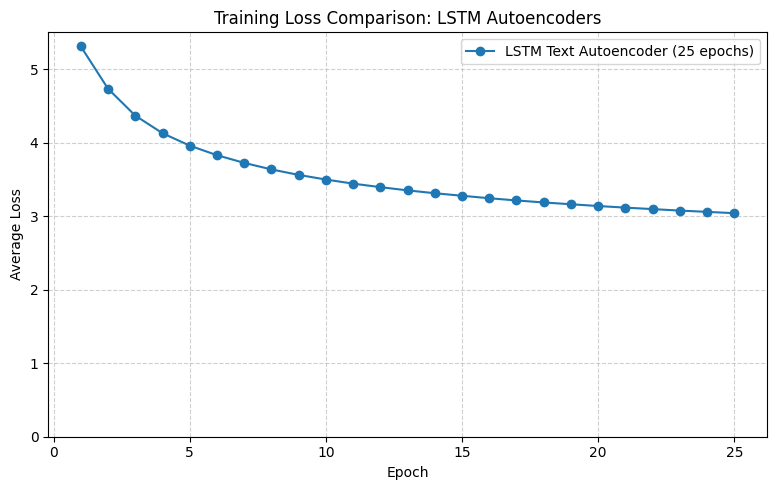

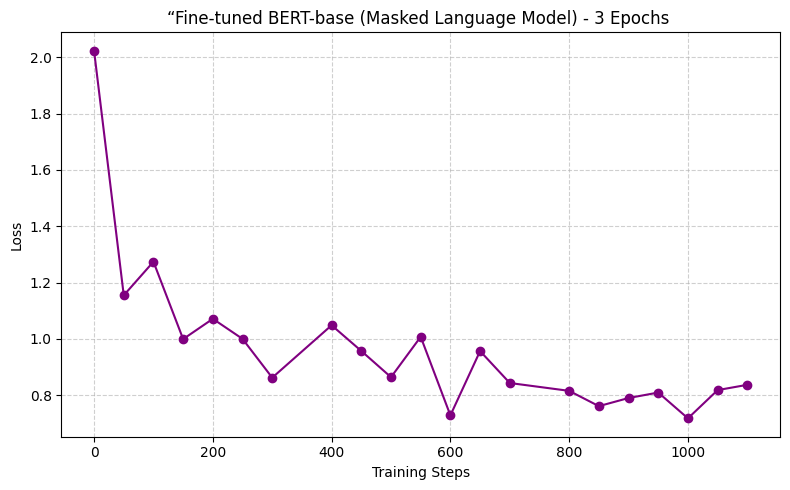

In [ ]:
import matplotlib.pyplot as plt
###### got those values output from previous cells ######
bert_steps = [
    0, 50, 100, 150, 200, 250, 300,   # Epoch 1
    400, 450, 500, 550, 600, 650, 700,  # Epoch 2
    800, 850, 900, 950, 1000, 1050, 1100  # Epoch 3
]
bert_losses = [
    2.0236, 1.1548, 1.2742, 0.9993, 1.0714, 1.0001, 0.8623,   # Epoch 1
    1.0485, 0.9572, 0.8641, 1.0075, 0.7285, 0.9568, 0.8434,   # Epoch 2
    0.8155, 0.7612, 0.7901, 0.8095, 0.7179, 0.8182, 0.8370    # Epoch 3
]
# --- LSTM Autoencoder (25 epochs) ---
lstm_avg_losses = [
    5.3082, 4.7326, 4.3670, 4.1282, 3.9590,
    3.8290, 3.7244, 3.6355, 3.5609, 3.4980,
    3.4421, 3.3944, 3.3505, 3.3118, 3.2771,
    3.2437, 3.2135, 3.1861, 3.1618, 3.1377,
    3.1159, 3.0957, 3.0756, 3.0584, 3.0402
]

epochs_lstm = range(1, 26)

# --- Plot both ---
plt.figure(figsize=(8,5))
plt.plot(epochs_lstm, lstm_avg_losses, marker='o', label='LSTM Text Autoencoder (25 epochs)')
# plt.plot(epochs_bert, bert_avg_losses, marker='s', label='Fine-tuned BERT (3 epochs)')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Comparison: LSTM Autoencoders")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(0, 5.5)   # show full 0–5 range on y-axis
plt.yticks(range(0, 6))   # tick marks at 0,1,2,3,4,5
plt.show()
#Plot BERT results

# Plot
plt.figure(figsize=(8,5))
plt.plot(bert_steps, bert_losses, marker='o', linestyle='-', color='purple')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("“Fine-tuned BERT-base (Masked Language Model) - 3 Epochs ")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# @title Image reonstruction task

# To-Do: Use previous labs if you want to pretrain your visual encoder

# **Appendix**

This code computes the average images in case you want to use them. Notice that the average should be all zeros!

In [ ]:
# @title Computing and showing average images
N = 1000
H, W = 60, 125

# Tensors to accumulate sum (for mean) and sum of squares (for variance)
avg_images = [torch.zeros((3, H, W)) for _ in range(5)]
sum_sq_diff = [torch.zeros((3, H, W)) for _ in range(5)] # Placeholder for variance numerator
transform = transforms.Compose([transforms.ToTensor()])

# --- First Pass: Calculate the Sum (for Mean) ---
print("Starting Pass 1: Calculating Mean...")

for i in range(N):
    # Process sequence i
    sequence = train_dataset[i]["images"]

    for j in range(5):
        image = transform(sequence[j])
        avg_images[j] += image # Sum for mean

# Final step for mean
for j in range(5):
    avg_images[j] /= N

print("Starting Pass 2: Calculating Variance...")

for i in range(N):
    # Process sequence i
    sequence = train_dataset[i]["images"]

    for j in range(5):
        image = transform(sequence[j])

        # Calculate (Image - Mean)^2
        # Note: We detach the mean from the computation graph if it were being trained,
        # but here we're just using it as a fixed statistical value.
        diff = image - avg_images[j]
        sum_sq_diff[j] += diff * diff # Element-wise squaring

# --- Final step for Standard Deviation ---
std_images = []
for j in range(5):
    # Variance = Sum of Squared Differences / N
    variance = sum_sq_diff[j] / N

    # Standard Deviation = sqrt(Variance)
    std_dev = torch.sqrt(variance)
    std_images.append(std_dev)

print("Computation Complete. std_images is a list of 5 tensors (3x60x125).")
# You now have the 5 tensors you need for normalization (mean and std).

fig, ax = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
  avg_image = avg_images[i]

  # Printing range of avg_image
  print(torch.min(avg_image), torch.max(avg_image))

  avg_imagen = (avg_image - torch.min(avg_image))/(torch.max(avg_image) - torch.min(avg_image))
  show_image(ax[i], avg_imagen)

# Create a matrix of images with the differences between avg_images
fig, ax = plt.subplots(5,5, figsize=(15,8))

for i in range(5):
  for j in range(5):
    if i == j:
      avg_image = avg_images[i]
      avg_imagen = (avg_image - torch.min(avg_image))/(torch.max(avg_image) - torch.min(avg_image))
      show_image(ax[i,j], avg_imagen)
    else:
      diff = avg_images[i] - avg_images[j]
      diff = (diff - torch.min(diff))/(torch.max(diff) - torch.min(diff))
      show_image(ax[i,j], diff)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
plt.tight_layout()
plt.subplots_adjust(
    wspace=0, # Set horizontal space to zero
    hspace=0  # Set vertical space to zero
)